In [1]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial
plt.rcParams.update({'font.size': 18})

From http://sheridan.geog.kent.edu/ssc/clusters/clusters.jpg, 
there are a couple of Spatial Synoptic Classification (SSC) zones in the continental US: 1,2,3a,3b, 3c, 5, 7,9. These correspond to: 

In [2]:
# build dictionary of  the synoptic zones
# return 'capital city', corresponding state, and station code
synoptic_spatial = {'1':['Jackson', 'MS', 'JAN'],
                   '2': ['Amarillo', 'TX', 'AMA'],
                   '3a': ['Alpena','MI', 'APN'],  
                    '3b': ['Glasgow', 'MT', 'GGW'],# don't really have these
                   '3c': ['Washington', '', 'DCA' ],
                    '5': ['Key West', 'FL', 'EYW'],
                    '7': ['Phoenix', 'AZ', 'PHX'],
                    '8': ['Seattle', 'WA', 'SEA'],
                   }

In [3]:
filepath = 'data/synopticclassification/'


In [4]:
# # read in our dataset
# pairs = pd.read_csv('NovUSpairs_stationlengths_stationavailability75.csv')
# paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
# paired_df = paired_df.drop(2)
# drop_cities = ['Mesa','Long Beach', 'Grand Prairie', 'Virginia Beach', 'St. Paul' ]
# paired_df = paired_df.set_index(paired_df['City']).drop(drop_cities)

In [5]:
paired_df = pd.read_csv('USpairs2005-2015.csv').set_index('City')
paired_df.head()

,Unnamed: 0,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end,Urban distance,Rural distance
City,,,,,,,,,,,,,,,
Mesa,0,USC00022782,33.419,-111.644,63.0,2002-08-01,2016-10-31,USC00020288,33.462,-111.481,13.0,1987-05-01,2016-10-31,0.092215,0.257912
Grand Prairie,1,USC00410337,32.757,-97.073,63.0,1893-01-01 00:00:00,2016-09-30,USR0000TLBJ,33.172,-97.375,8.0,2000-01-01,2016-09-30,0.089455,0.602709
Irvine,2,USC00047888,33.744,-117.866,63.0,1916-05-01,2016-11-30,USR0000CFRE,33.808,-117.711,18.0,1991-07-01,2016-11-30,0.073097,0.174437
New Haven,3,USC00307134,40.961,-72.715,37.0,1938-03-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-12-31,0.413123,0.716986
Fort Lauderdale,4,USC00083168,26.140,-80.106,63.0,1952-04-01,2016-09-30,USR0000FCAC,25.390,-80.680,4.0,1999-12-01,2016-11-30,0.036001,0.919939


In [7]:
# plotting 
# define functions used for plotting 
def lin_trend_plot(start_x, y,title = '', xlabel = '', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y.values)# & ~np.isnan(x) # subset values that aren't NaNs
    x = np.arange(0,y.shape[0])
    m, b, r_value, p, std_err = scipy.stats.linregress(x[ind],y[ind])
    plt.scatter(x+start_x,y)
    plt.plot(x+start_x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r_value), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, b, r_value, p, std_err

In [8]:
# Mann-Kendall trend test, by http://michaelpaulschramm.com/simple-time-series-trend-analysis/
# modified from the original by Sat Kumar Tomer, http://pydoc.net/Python/ambhas/0.4.0/ambhas.stats/
import numpy as np  
from scipy.stats import norm, mstats


def mk_test(x, alpha = 0.05):  
    """   
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics 

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05) 
    """
    n = len(x)

    # calculate S 
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
            z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2) 

    if (z<0) and h:
        trend = 'decreasing'
    elif (z>0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z

In [353]:
cities = paired_df.index
ssc_trend_result = pd.DataFrame(np.ones([ cities.shape[0],4])*np.nan, 
            index = cities)
years = range(1985, 2016)
for city in cities:    
#city = 'Washington'
    print(city)
    ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
    if city == 'Washington, D.C.': 
        ssc_code = np.array(['IAD'])
    if ssc_code.shape[0] > 0: 
        file = filepath + ssc_code[0] + '.dbdmt'
        synopticDF =  pd.read_table(file, sep = ' ', header =  None)
        synopticDF.columns = ['id','date', 'ssc']
        synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
        synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
        synopticDF = synopticDF.loc['1985-06-01':]
        
        counts = pd.DataFrame([])
        for year in years:
            counts[year] = synopticDF['ssc']['%s-06-01'%year:'%s-08-31'%year].value_counts().sort_index()
        dry = counts.loc[[1,2,3]].sum()
        moist = counts.loc[[4,5,6,6.5]].sum()
        dry_reg = scipy.stats.linregress(dry.index, dry.values) # m, b, r_value, p, std_err
        dry_test = mk_test(dry.values) # trend true/false, h,p,z
        moist_reg = scipy.stats.linregress(moist.index, moist.values)
        moist_test = mk_test(moist.values)

        ssc_trend_result.loc[city] = [dry_reg[0], dry_test[0], moist_reg[0], moist_test[0]]
        ssc_trend_result.to_csv(results_filepath+ 'ssctrendresult.csv')
ssc_trend_result.columns = ['M_dry', 'Dry trend', 'M_moist', 'Moist trend']
ssc_trend_result.to_csv(results_filepath+ 'ssctrendresult.csv')

Mesa
Grand Prairie
Irvine
New Haven
Fort Lauderdale
Long Beach
Hartford
Providence
Birmingham
St. Petersburg
Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Detroit
San Francisco
Denver
Houston
Miami
Atlanta
Chicago
Los Angeles
Washington, D.C.
New York


In [365]:
ssc_trend_result.to_csv(results_filepath+ 'ssctrendresult.csv')

In [355]:
ssc_trend_result.columns = ['M_dry', 'Dry trend', 'M_moist', 'Moist trend']

In [360]:
ssc_trend_result = ssc_trend_result[~np.isnan(ssc_trend_result['M_dry'])]

In [362]:
ssc_trend_result[ssc_trend_result['Dry trend'] != 'no trend']

,M_dry,Dry trend,M_moist,Moist trend
City,,,,
Oakland,0.822581,increasing,-0.174597,no trend
West Palm Beach,-0.091129,decreasing,0.066935,no trend
Fresno,-0.255645,decreasing,-0.019758,no trend
Las Vegas,-0.317339,decreasing,0.310484,increasing
Buffalo,-0.302016,decreasing,0.383065,increasing
Honolulu,-0.185887,decreasing,0.045161,no trend
Phoenix,-0.421774,decreasing,-0.081452,no trend
Tampa,-0.219355,decreasing,0.146371,no trend
San Francisco,-0.452016,decreasing,0.441935,increasing


In [364]:
ssc_trend_result.shape

(58, 4)

In [363]:
ssc_trend_result[ssc_trend_result['Dry trend'] != 'no trend'].shape

(11, 4)

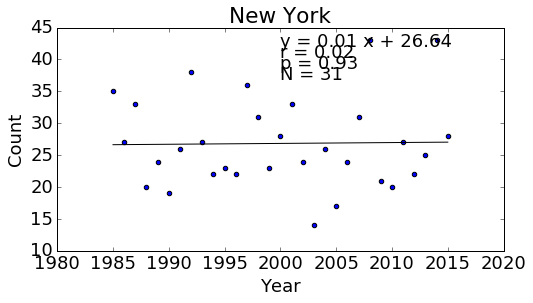

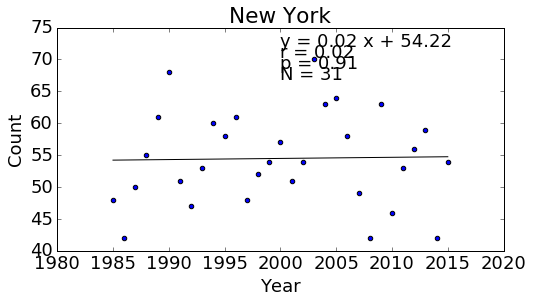

In [310]:
plt.figure(figsize=[8,4])
m,b,r,p,err = lin_trend_plot(years[0], dry, '%s'%city, 'Year', 'Count')
plt.figure(figsize=[8,4])
m,b,r,p,err = lin_trend_plot(years[0], moist, '%s'%city, 'Year', 'Count')

[1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015]

In [300]:
counts

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
1.0,29,19.0,30.0,12,21.0,15.0,24.0,31.0,24.0,20.0,...,21.0,26,40.0,19,20.0,27.0,18.0,21.0,43.0,27.0
2.0,6,8.0,3.0,8,3.0,4.0,2.0,7.0,3.0,2.0,...,3.0,5,3.0,2,NaN,NaN,4.0,4.0,NaN,1.0
4.0,21,17.0,19.0,23,33.0,30.0,18.0,26.0,22.0,22.0,...,28.0,17,13.0,29,11.0,13.0,16.0,21.0,17.0,8.0
5.0,3,NaN,2.0,3,2.0,3.0,NaN,5.0,1.0,NaN,...,NaN,3,NaN,5,NaN,NaN,1.0,1.0,NaN,5.0
6.0,22,23.0,19.0,22,20.0,33.0,20.0,14.0,25.0,32.0,...,26.0,26,26.0,28,25.0,34.0,33.0,27.0,24.0,31.0
6.5,2,2.0,10.0,7,6.0,2.0,13.0,2.0,5.0,6.0,...,4.0,3,3.0,1,10.0,6.0,6.0,10.0,1.0,10.0
7.0,8,18.0,6.0,9,2.0,5.0,6.0,3.0,5.0,4.0,...,3.0,8,3.0,7,10.0,5.0,4.0,4.0,5.0,4.0
8.0,1,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN


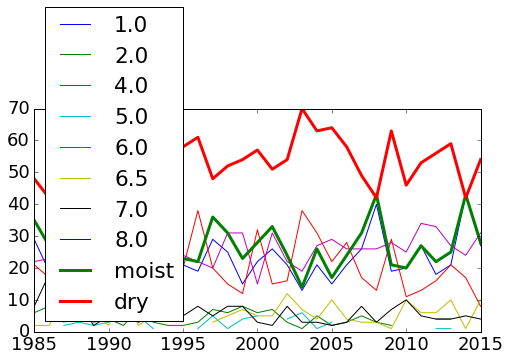

In [305]:
counts.T.plot(figsize = [8,4])
dry.plot(linewidth = 3,label = 'moist')
moist.plot(linewidth = 3,label = 'dry')
plt.legend(loc=3)

In [ ]:
fig, ax = pyplot.subplots()
df.plot(x='xcol', y='ycol', ax=ax)

In [8]:
# cities = ['Birmingham', 'BHM',#1
#           'Albuquerque', 'ABQ', #2
#         'Buffalo', 'BUF',  #3a
#           'Washington, D.C.','IAD', #3c
#           'Miami', 'MIA',#5
#          'Phoenix','PHX', #7
#          'Seattle', 'SEA' #8
#          ]

In [35]:
filepath = 'data/synopticclassification/'
synopticDF =pd.read_table(filepath+'bham.txt', 
                          header = None, 
                          sep = ' ', nrows=5, index_col = 1,
              parse_dates = True, infer_datetime_format = True)
synopticDF.columns = ['id','ssc']

In [485]:
ls data/synopticclassification/

ABQ.dbdmt      IND.dbdmt      PHX.dbdmt      abq.txt        pbi.txt
ATL.dbdmt      JAX.dbdmt      PIT.dbdmt      aus.txt        pdx.txt
AUS.dbdmt      LAS.dbdmt      PVD.dbdmt      bdl.txt        phx.txt
BDL.dbdmt      LAX.dbdmt      PWM.dbdmt      bhm.txt        pvd.txt
BHM.dbdmt      MCI.dbdmt      RDU.dbdmt      buf.txt        ric.txt
BNA.dbdmt      MCO.dbdmt      RIC.dbdmt      clt.txt        sac.txt
BUF.dbdmt      MEM.dbdmt      SAC.dbdmt      cmh.txt        sdf.txt
BWI.dbdmt      MIA.dbdmt      SAN.dbdmt      elp.txt        sea.txt
CLE.dbdmt      MSP.dbdmt      SAT.dbdmt      fat.txt        sjc.txt
CLT.dbdmt      MSY.dbdmt      SDF.dbdmt      iad.txt        slc.txt
CSG.dbdmt      OAK.dbdmt      SEA.dbdmt      ind.txt        stations.html
DEN.dbdmt      OFK.dbdmt      SJC.dbdmt      jax.txt        stations.txt
DFW.dbdmt      OKC.dbdmt      SLC.dbdmt      las.txt        tul.txt
ELP.dbdmt      OMA.dbdmt      STL.dbdmt      mco.txt        tus.txt
FAT.dbdmt      OMA.dbdmt.1    TPA.dbd

In [2]:
import scipy.stats
def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y, color = 'grey')
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p
def prettify_plot(): 
    ""'Hides top and rightmos axis spines and also some other stuff. '""
    figures = [x for x in matplotlib._pylab_helpers.Gcf.get_all_fig_managers()]
    for figure in figures:
        # Get all Axis instances related to the figure.
        for ax in figure.canvas.figure.get_axes():
            # Disable spines.
            ax.spines['right'].set_color('none')
            ax.spines['top'].set_color('none')
            # Disable ticks.
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_axis_bgcolor('none')
    plt.grid(b=False, which='major')


In [7]:
stations.head()

,"Station,ID,Years"
0,"Zolotoy Mys , Russia,ZLY,1966-1976 1978-1985 1..."
1,"Aberdeen , Scotland,ABZ,1973-2016"
2,"Aberdeen , SD,ABR,1948-1954 1964-1978 1983-198..."
3,"Abilene , TX,ABI,1947-2016"
4,"Adak , AK,ADK,1943-1993 2005-2016"


In [9]:
stations = pd.read_table('data/synopticclassification/stations.txt', sep = ',')

In [13]:
# form a list of stations to download using wget
stations = pd.read_table('data/synopticclassification/stations.txt', sep = ',')
wget_urls = []
f=open('wget_urls.txt','w')

for city in paired_df.index:
#city = paired_df.index[0]
    ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
    url = 'http://sheridan.geog.kent.edu/ssc/files/' + ssc_code + '.dbdmt'
    if url.shape[0]>0 :
        wget_urls.append(url+'\n')
        f.write(url[0]+'\n')
f.close()
#wget -i wget_urls.txt 

In [12]:
results_filepath = 'plots/version5/ssc/'

In [11]:
ls plots/version5/ssc/

rural_sscanalysis.csv           sscanalysis_allcities.csv
sscanalysis.csv                 ssctrendresult.csv
sscanalysisMarinePolaronly.csv  urban_sscanalysis.csv
sscanalysis_2005pairs.csv


In [16]:
cities = paired_df.index
# resultsDF = pd.DataFrame(np.ones([len(cities), 7])*np.nan, index = cities, 
#                          columns=['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP'])
# cities = ['Hartford',  'New York',  'Baltimore',  'Philadelphia', 
#              #'Washington, D.C.', 'Richmond','Norfolk',
#              #'Providence',  'Buffalo', 'Pittsburgh',
#             ]
resultsDF = pd.DataFrame(np.ones([len(cities), 7])*np.nan, index = cities, 
                          columns=['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP'])
urban_resultsDF = pd.DataFrame(np.ones([len(cities), 7])*np.nan, index = cities, 
                          columns=['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP'])
rural_resultsDF = pd.DataFrame(np.ones([len(cities), 7])*np.nan, index = cities, 
                          columns=['DM', 'DP', 'DT', 'MM', 'MP', 'MT', 'MTP'])
for city in paired_df.index: # cities[66:]: #paired_df.iloc[66:].index: #paired_df.index: 
#city = 'Washington'
    print(city)
    ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
    if city == 'Washington, D.C.': 
        ssc_code = np.array(['IAD'])
    if ssc_code.shape[0] > 0: 
        file = filepath + ssc_code[0] + '.dbdmt'
        synopticDF =  pd.read_table(file, sep = ' ', header =  None)
        synopticDF.columns = ['id','date', 'ssc']
        synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
        synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
        synopticDF = synopticDF.loc['1985-06-01':]

        urbanID = paired_df.loc[city]['Urban station']
        ruralID = paired_df.loc[city]['Rural station']
        # Downloadd from NCDC the station data, using the station ID listed in station list
        urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                             as_dataframe=True, update = False)
        ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                             as_dataframe=True, update = False)
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        # clean data: eliminate data with flags     
        rural_tmin[~ruraldata['TMIN']['qflag'].isnull()] = np.nan
        urban_tmin[~urbandata['TMIN']['qflag'].isnull()] = np.nan

        # extract summertime data 
        rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
        urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

        # clean data: eliminate min temperatures below 4 or above 35
#         rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
#         urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]


        #calculate UHI
        UHI = urban_summer - rural_summer

        #mean_UHI_dry_ssc = UHI[synopticDF['ssc'][synopticDF['ssc']<3].index].mean()
        #mean_UHI_wet_ssc = UHI[synopticDF['ssc'][(synopticDF['ssc']>=4) & (synopticDF['ssc']<6)].index].mean()
        resultsDF.loc[city] = [UHI[synopticDF['ssc']==1].mean(), 
                               UHI[synopticDF['ssc']==2].mean(), 
                               UHI[synopticDF['ssc']==3].mean(), 
                               UHI[synopticDF['ssc']==4].mean(),
                               UHI[synopticDF['ssc']==5].mean(),
                               UHI[synopticDF['ssc']==6].mean(), 
                               UHI[synopticDF['ssc']==6.5].mean(), 
        ]
        
        urban_resultsDF.loc[city] = [urban_summer[synopticDF['ssc']==1].mean(), 
                               urban_summer[synopticDF['ssc']==2].mean(), 
                               urban_summer[synopticDF['ssc']==3].mean(), 
                               urban_summer[synopticDF['ssc']==4].mean(),
                               urban_summer[synopticDF['ssc']==5].mean(),
                               urban_summer[synopticDF['ssc']==6].mean(), 
                               urban_summer[synopticDF['ssc']==6.5].mean(), 
        ]
        
        rural_resultsDF.loc[city] = [rural_summer[synopticDF['ssc']==1].mean(), 
                               rural_summer[synopticDF['ssc']==2].mean(), 
                               rural_summer[synopticDF['ssc']==3].mean(), 
                               rural_summer[synopticDF['ssc']==4].mean(),
                               rural_summer[synopticDF['ssc']==5].mean(),
                               rural_summer[synopticDF['ssc']==6].mean(), 
                               rural_summer[synopticDF['ssc']==6.5].mean(), 
        ]
        #plt.savefig(results_filepath+ '%s.png'%city)
        #plt.close()

        #resultsDF.loc[city]  = [mean_UHI_dry_ssc, mean_UHI_wet_ssc]
        #resultsDF.columns = ['Dry SSC UHI', 'Wet SSC UHI', 'r']
        resultsDF.to_csv(results_filepath+'sscanalysis.csv')
        urban_resultsDF.to_csv(results_filepath+'urban_sscanalysis.csv')
        rural_resultsDF.to_csv(results_filepath+'rural_sscanalysis.csv')

    else: 
        print('No synoptic station for %s'%city)
resultsDF['Dry'] = resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
resultsDF['Moist'] = resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
resultsDF.to_csv(results_filepath+'sscanalysis.csv')

urban_resultsDF['Dry'] = urban_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
urban_resultsDF['Moist'] = urban_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
urban_results.to_csv(results_filepath+'urban_sscanalysis.csv')

rural_resultsDF['Dry UHI'] = rural_resultsDF[['DM', 'DP', 'DT']].mean(axis=1)
rural_resultsDF['Moist UHI'] = rural_resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)
rural_resultsDF.to_csv(results_filepath+'rural_sscanalysis.csv')

Mesa
No synoptic station for Mesa
Grand Prairie
No synoptic station for Grand Prairie
Irvine
No synoptic station for Irvine
New Haven
No synoptic station for New Haven
Fort Lauderdale
No synoptic station for Fort Lauderdale
Long Beach
No synoptic station for Long Beach
Hartford
Providence
Birmingham
St. Petersburg
No synoptic station for St. Petersburg
Virginia Beach
No synoptic station for Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
No synoptic station for San Bernardino
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Sacramento
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
No synoptic station for Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Pittsburgh
Minneapolis
Honolulu
Seattle
Phoenix
San Diego
St. Louis
New Orleans
Dallas
Tampa
Philadelphia
Detroit
San Francisco
Denver
Houston
Miami
Atlanta
C

In [18]:
results_filepath

'plots/version5/ssc/'

In [374]:
paired_df[paired_df['Urban distance']< .2].index

Index([u'Mesa', u'Grand Prairie', u'Irvine', u'Fort Lauderdale', u'Long Beach',
       u'Hartford', u'Providence', u'Virginia Beach', u'Oakland',
       u'West Palm Beach', u'Louisville', u'Columbus', u'San Bernardino',
       u'St. Paul', u'Tucson', u'Fresno', u'Albuquerque', u'Ft. Worth',
       u'Austin', u'Indianapolis', u'Baltimore', u'San Jose', u'Sacramento',
       u'Las Vegas', u'Portland', u'Omaha', u'Raleigh', u'Cleveland',
       u'Cincinnati', u'Nashville', u'Norfolk', u'Milwaukee', u'Buffalo',
       u'Pittsburgh', u'Minneapolis', u'Honolulu', u'Seattle', u'Phoenix',
       u'San Diego', u'St. Louis', u'New Orleans', u'Dallas', u'Philadelphia',
       u'Detroit', u'San Francisco', u'Denver', u'Miami', u'Chicago',
       u'Los Angeles', u'Washington, D.C.', u'New York'],
      dtype='object', name=u'City')

In [389]:
from scipy import stats
stats.ttest_1samp((resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].values,0)

Ttest_1sampResult(statistic=3.650924555249631, pvalue=0.00086957943949231363)

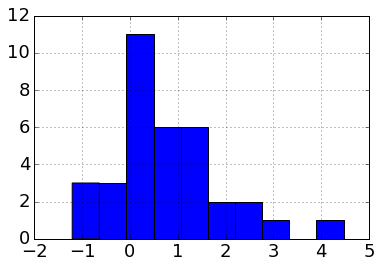

In [388]:
(resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].hist()

In [21]:
# mean difference in UHI on dry days minus moist days 
(resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].mean(), stats.ttest_1samp((resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].values,0)

(0.5125553750089631, Ttest_1sampResult(statistic=nan, pvalue=nan))

In [380]:
# mean difference in UHI on dry days minus moist days 
(resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].mean()

0.7278895210801507

In [381]:
# mean difference in UHI on dry days minus moist days 
(resultsDF['Dry UHI']- resultsDF['Moist UHI']).loc[paired_df['Urban distance']< .2].std()

1.1794964302399569

In [385]:
(paired_df['Urban distance']< .2).sum()

51

In [386]:
paired_df[paired_df['Urban distance']< .2].shape

(51, 15)

In [387]:
#what about 'oppressive' weather types? 
(resultsDF['DT']- resultsDF['MT']).loc[paired_df['Urban distance']< .2].mean()

0.5445729971725539

In [199]:
resultsDF = resultsDF[resultsDF['DM']> 0]

In [171]:
synopticDF =  pd.read_table(file, sep = ' ', header =  None)
synopticDF.columns = ['id','date', 'ssc']
synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
synopticDF = synopticDF.loc['1985-06-01':]

In [200]:
synopticDF.head()

,id,date,ssc
month_period,,,
1985-06-01,JFK,19850601,7.0
1985-06-02,JFK,19850602,6.0
1985-06-03,JFK,19850603,6.0
1985-06-04,JFK,19850604,1.0
1985-06-05,JFK,19850605,4.0


In [80]:
city = 'Baltimore'
ssc_code = stations[stations['Station'].str.contains(city)]['ID'].values
if city == 'Washington, D.C.': 
    ssc_code = np.array(['IAD'])
if ssc_code.shape[0] > 0: 
    file = filepath + ssc_code[0] + '.dbdmt'
    synopticDF =  pd.read_table(file, sep = ' ', header =  None)
    synopticDF.columns = ['id','date', 'ssc']
    synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
    synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
    synopticDF = synopticDF.loc['1985-06-01':]

    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 

    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

    # clean data: eliminate min temperatures below 4 or above 35
    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer


In [143]:
# ruraldata = ulmo.ncdc.ghcn_daily.get_data('USW00093721',
#                                      as_dataframe=True, update = False)
# rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
# urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 

# extract summertime data 
rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

# # clean data: eliminate min temperatures below 4 or above 35
# rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
# urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

#calculate UHI
UHI = urban_summer - rural_summer

In [141]:
synopticDF['ssc']['2009-06-01':'2009-08-30'].shape, UHI['2009-06-01':'2009-08-30'].shape

((91,), (91,))

(0, 8)

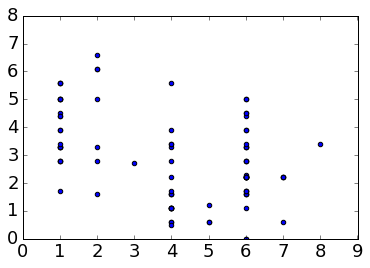

In [173]:
#UHI[synopticDF['ssc']<=3]['2009-06-01':'2009-09-01']
plt.scatter(synopticDF['ssc']['2009-06-01':'2009-08-30'], UHI['2009-06-01':'2009-08-30'])
plt.ylim(0,8)

In [165]:
urban_tmin['2009-06-01':'2009-06-30'] - rural_tmin['2009-06-01':'2009-06-30']

month_period
2009-06-01    6.6
2009-06-02    3.3
2009-06-03    0.0
2009-06-04    1.2
2009-06-05    0.6
2009-06-06    0.6
2009-06-07    3.3
2009-06-08    1.6
2009-06-09    1.6
2009-06-10    3.3
2009-06-11    0.6
2009-06-12    1.6
2009-06-13    2.8
2009-06-14    3.3
2009-06-15    3.9
2009-06-16    1.1
2009-06-17    0.6
2009-06-18    1.1
2009-06-19    3.3
2009-06-20    2.2
2009-06-21    1.1
2009-06-22    2.2
2009-06-23    2.2
2009-06-24    3.9
2009-06-25    4.5
2009-06-26    3.9
2009-06-27    3.4
2009-06-28    5.6
2009-06-29    3.9
2009-06-30    5.0
Freq: D, Name: value, dtype: float64

In [167]:
UHI['2009-06-03']

0.0

In [170]:
synopticDF.loc['2009-06-03']

id           BWI
date    19840603
ssc            1
Name: 2009-06-03, dtype: object

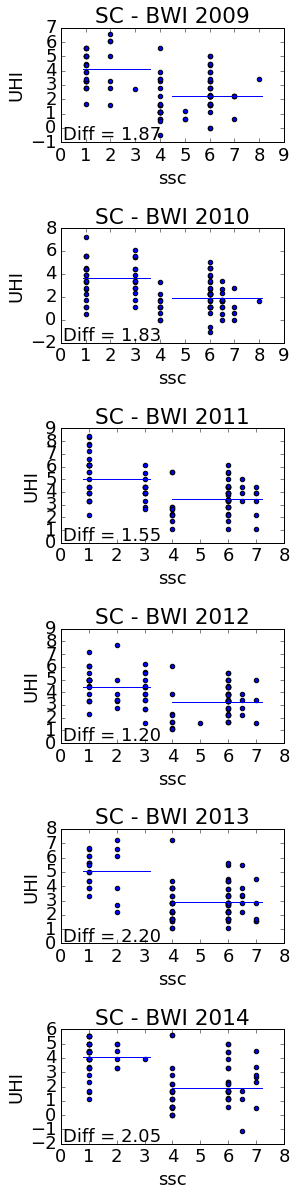

In [174]:
# see if we can reproduce darryn's plots
fig, axes = plt.subplots(6,1, figsize = [4,20])
plt.subplots_adjust(hspace=0.75)
i = 0
for year in range(2009, 2015): 
    x = synopticDF['ssc']
    y = UHI['%s-06-01'%year:'%s-08-30'%year]
    x = x[y.index]
    axes[i].scatter(x, y)
    d =y[x<=3].mean() - y[x>3].mean()
    axes[i].axhline(y[x<=3].mean(), xmin = .1, xmax=.4)
    axes[i].axhline(y[(x>3) & (x<7)].mean(), xmin = .5, xmax=.9)
    axes[i].annotate('Diff = %2.2f'%d , xy = (0.01,0.02), xycoords = 'axes fraction')
    axes[i].set_xlabel('ssc')
    axes[i].set_ylabel('UHI')
    axes[i].set_title('SC - BWI %s'%( year))
    i = i+1

In [60]:
synopticDF =  pd.read_table(file, sep = ' ', header =  None)
synopticDF.columns = ['id','date', 'ssc']
synopticDF.index = pd.PeriodIndex(synopticDF['date'], freq = 'D', name = 'month_period')
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
synopticDF = synopticDF.loc['1985-06-01':]

In [65]:
UHI[synopticDF['ssc']<=3].mean()

6.156140350877184

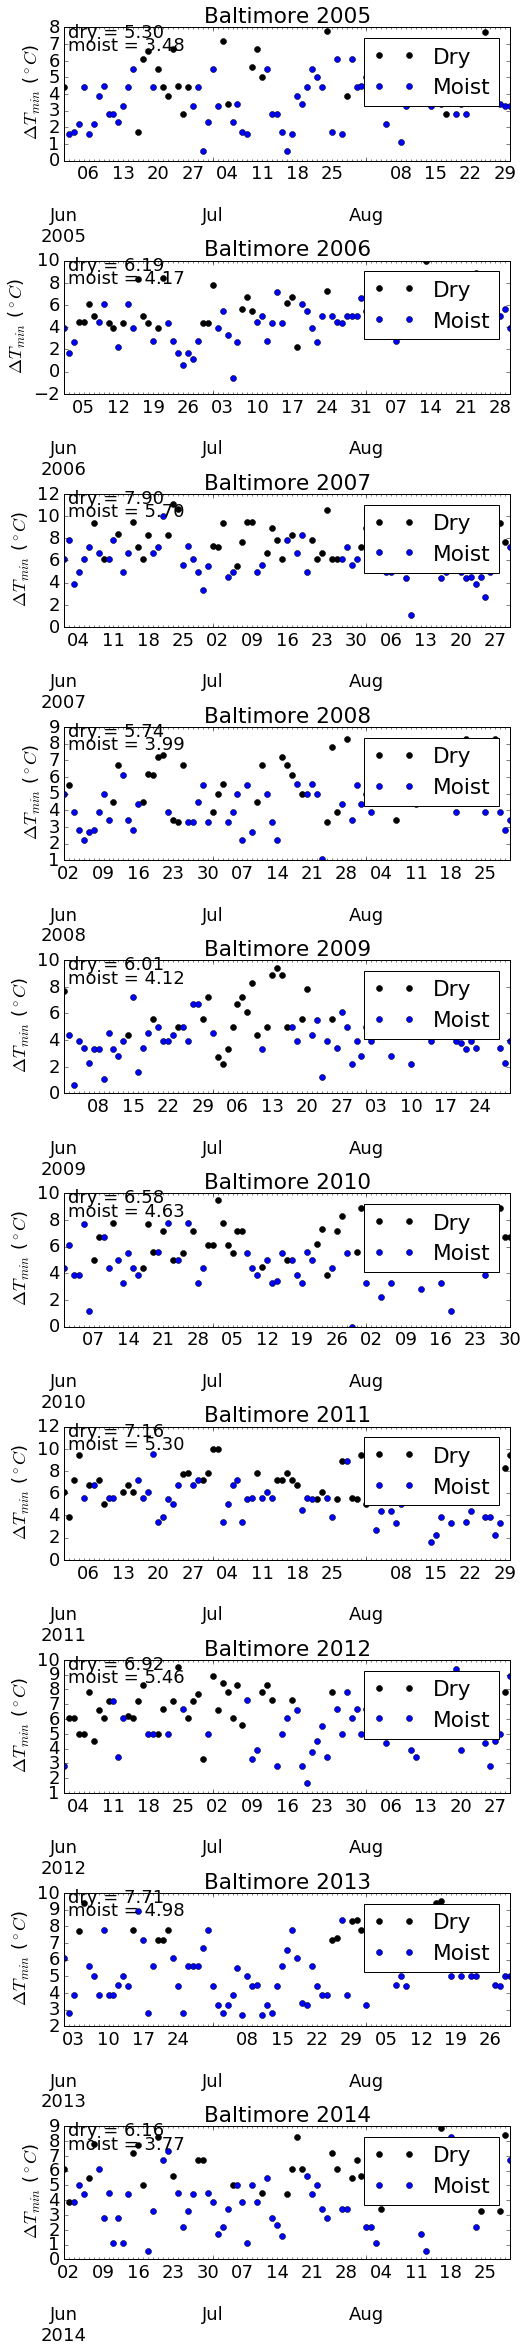

In [66]:
fig, axes = plt.subplots(10,1, figsize = [8,40])
plt.subplots_adjust(hspace=0.75)
i = 0
for year in range(2005,2015): 
    
#     UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ok', ax = axes[i])
#     UHI[synopticDF['ssc'][synopticDF['ssc']>3].index]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ob', ax = axes[i])
    UHI[synopticDF['ssc']<=3]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ok', ax = axes[i])
    UHI[synopticDF['ssc']>3]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ob', ax = axes[i])
    axes[i].legend(['Dry', 'Moist'])
    axes[i].set_title('%s %s'%(city, year))
    axes[i].set_ylabel(' $\Delta T_{min}$ ($^\circ C$)')
    axes[i].annotate('dry = %2.2f'%(UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index]['%s-06-01'%year:'%s-08-30'%year].mean()),
                 xy=(.01, .9), 
                 xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    axes[i].annotate('moist = %2.2f'%(UHI[synopticDF['ssc'][synopticDF['ssc']>3].index]['%s-06-01'%year:'%s-08-30'%year].mean()), 
                 xy=(.01, .8), 
                 xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    i = i+1

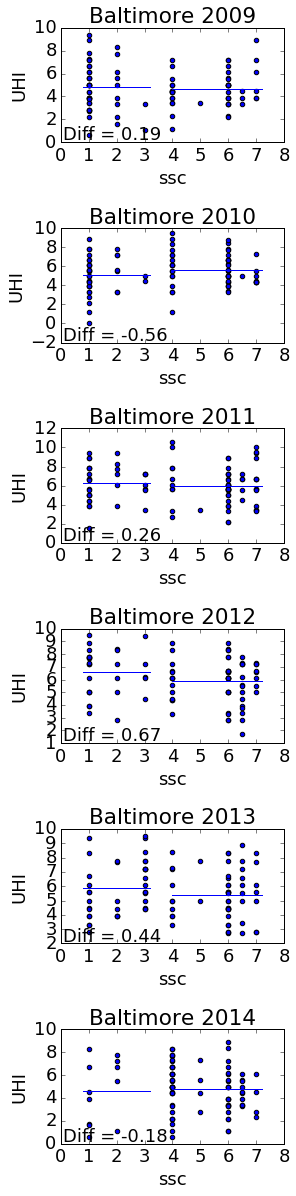

In [130]:
fig, axes = plt.subplots(6,1, figsize = [4,20])
plt.subplots_adjust(hspace=0.75)
i = 0
for year in range(2009, 2015): 
    x = synopticDF['ssc']
    y = UHI['%s-06-01'%year:'%s-08-30'%year]
    x = x[y.index]
    axes[i].scatter(x, y)
    d =y[x<=3].mean() - y[x>3].mean()
    axes[i].axhline(y[x<=3].mean(), xmin = .1, xmax=.4)
    axes[i].axhline(y[x>3].mean(), xmin = .5, xmax=.9)
    axes[i].annotate('Diff = %2.2f'%d , xy = (0.01,0.02), xycoords = 'axes fraction')
    axes[i].set_xlabel('ssc')
    axes[i].set_ylabel('UHI')
    axes[i].set_title('%s %s'%(city, year))
    i = i+1

In [658]:
city

'New York'

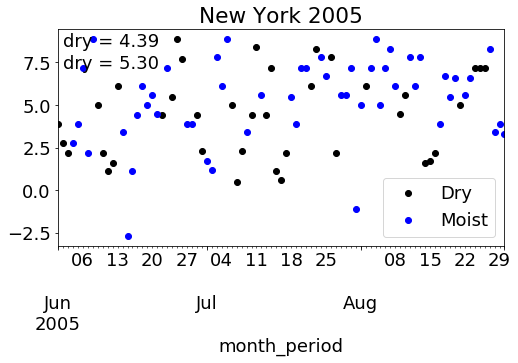

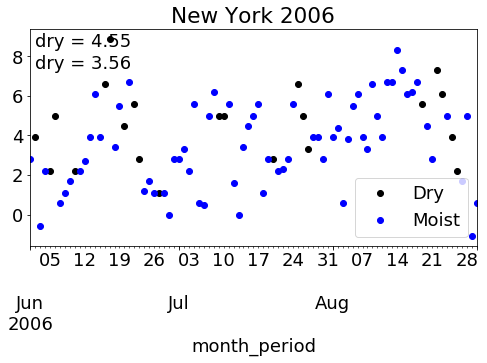

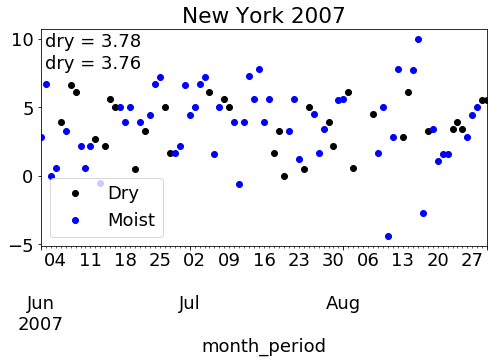

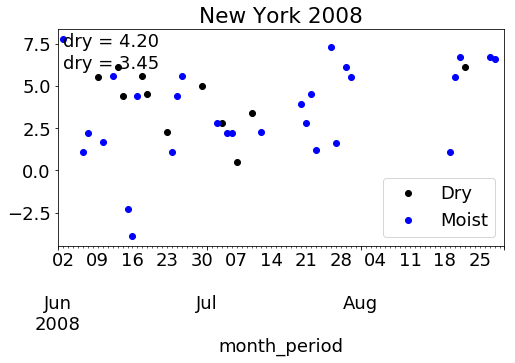

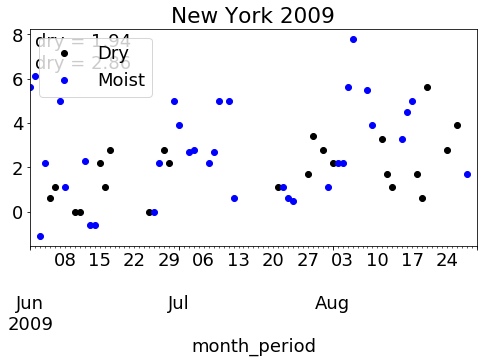

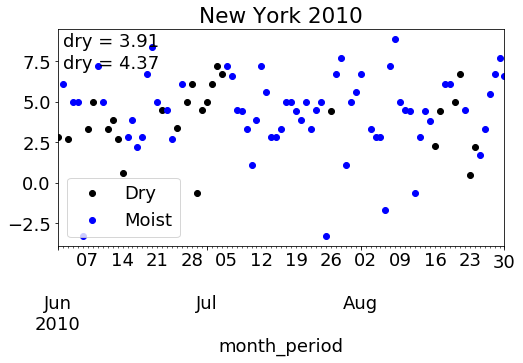

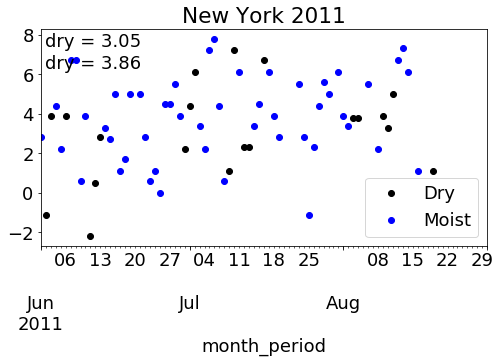

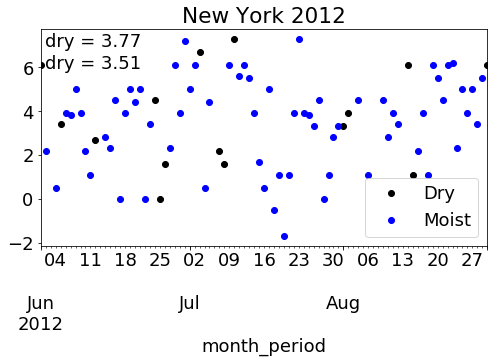

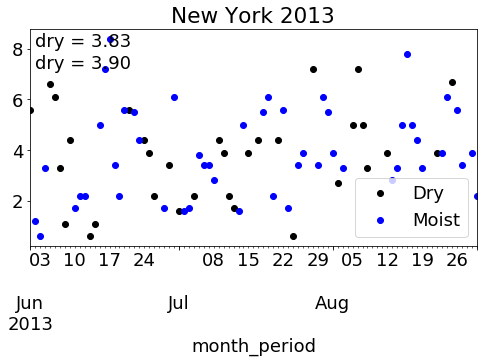

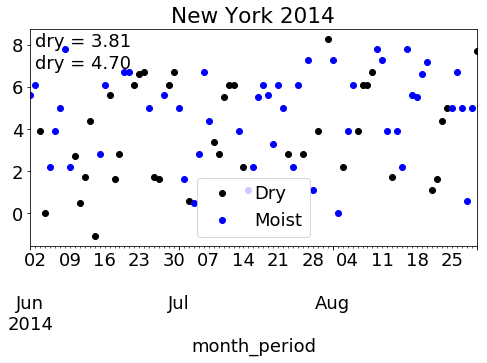

In [695]:
for year in range(2005,2015): 
    plt.figure(figsize = [8,4])
    UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ok')
    UHI[synopticDF['ssc'][synopticDF['ssc']>3].index]['%s-06-01'%year:'%s-08-30'%year].plot( style ='ob')
    plt.legend(['Dry', 'Moist'])
    plt.title('%s %s'%(city, year))
    plt.annotate('dry = %2.2f'%(UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index]['%s-06-01'%year:'%s-08-30'%year].mean()),
                 xy=(.01, .9), 
                 xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('dry = %2.2f'%(UHI[synopticDF['ssc'][synopticDF['ssc']>3].index]['%s-06-01'%year:'%s-08-30'%year].mean()), 
                 xy=(.01, .8), 
                 xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
# UHI[synopticDF['ssc'][synopticDF['ssc']==2].index]['2005-06-01':'2005-08-30'].plot( style ='o')
# UHI[synopticDF['ssc'][synopticDF['ssc']==3].index]['2005-06-01':'2005-08-30'].plot( style ='og')

In [687]:
plt.text?

In [536]:
resultsDF = resultsDF[resultsDF['DM']>0]

In [544]:
resultsDF['Dry UHI'] =resultsDF[['DM', 'DP', 'DT']].mean(axis=1)

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [545]:
resultsDF['Moist UHI'] = resultsDF[['MM', 'MP', 'MT', 'MTP']].mean(axis=1)

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [207]:
good_index = paired_df[paired_df['Urban distance']< .1].index

('Mean Difference is: ', 1.0038185211033641)


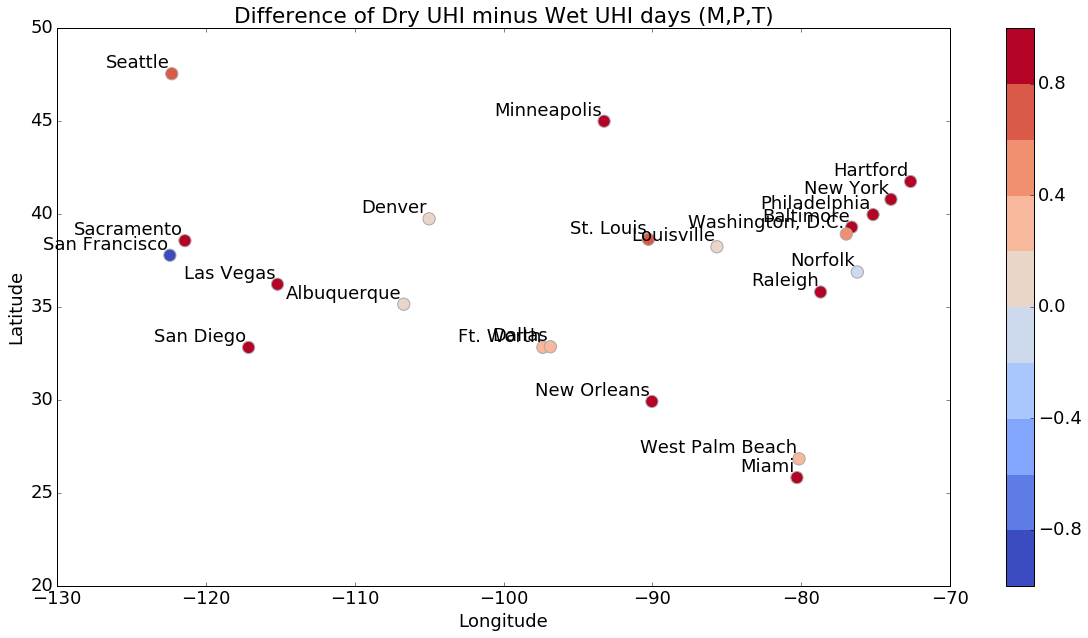

In [208]:
import matplotlib
fig = plt.figure(figsize=[20,10])
data = (resultsDF['Dry UHI'] - resultsDF['Moist UHI']).loc[good_index]#.drop(['Washington, D.C.', 'Norfolk', 'Raleigh'])
# Set up colors for plotting
cmap = plt.cm.coolwarm
c = data[~np.isnan(data)]
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Difference of Dry UHI minus Wet UHI days (M,P,T)')
for label, x, y in zip(c.index,paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, 2),
        textcoords='offset points', ha='right', va='bottom',
        bbox=None, #dict(boxstyle=None, fc='None', alpha=0.5),
        arrowprops=None, #dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    )
print('Mean Difference is: ', data.mean())

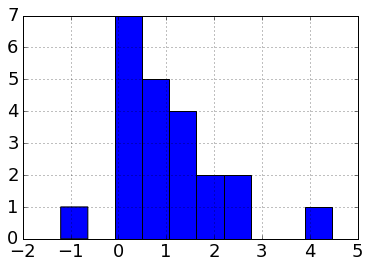

In [209]:
data.hist()

('Mean Difference is: ', 0.7568697708610609)


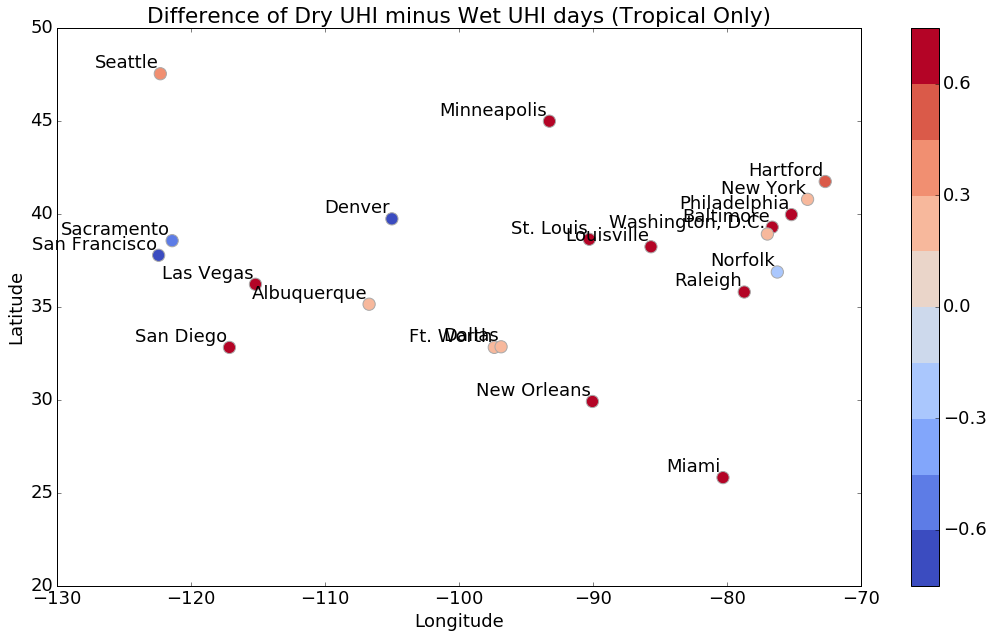

In [212]:
data = (resultsDF['DT'] - resultsDF['MT']).loc[good_index]
fig = plt.figure(figsize=[18,10])
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data[~np.isnan(data)]
bounds = np.linspace(-.75,.75,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Difference of Dry UHI minus Wet UHI days (Tropical Only)')
for label, x, y in zip(c.index,paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, 2),
        textcoords='offset points', ha='right', va='bottom',
        bbox=None, #dict(boxstyle=None, fc='None', alpha=0.5),
        arrowprops=None, #dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    )
print('Mean Difference is: ', data.mean())

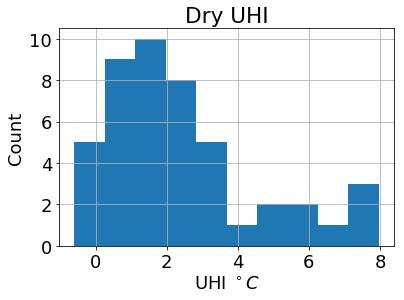

In [656]:
resultsDF['Dry UHI'].hist()
plt.xlabel('UHI $^\circ C$')
plt.ylabel('Count')
plt.title('Dry UHI')

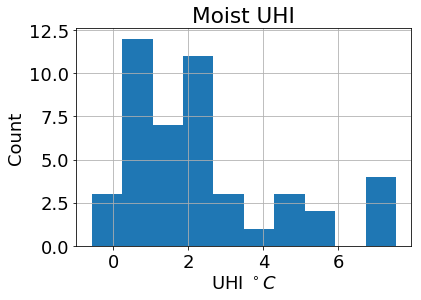

In [655]:
resultsDF['Moist UHI'].hist()
plt.xlabel('UHI $^\circ C$')
plt.ylabel('Count')
plt.title('Moist UHI')

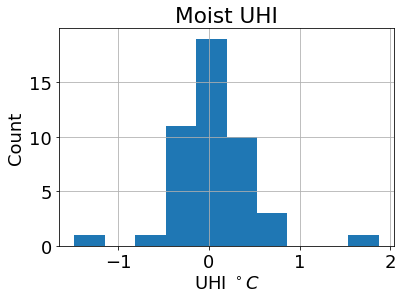

In [657]:
(resultsDF['Dry UHI'] - resultsDF['Moist UHI']).hist()
plt.xlabel('UHI $^\circ C$')
plt.ylabel('Count')
plt.title('Moist UHI')

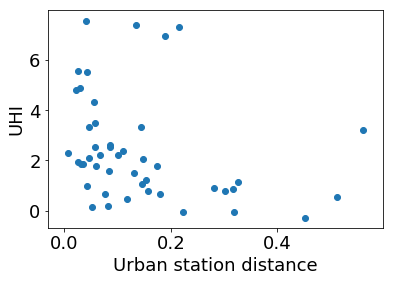

In [620]:
plt.scatter(
            paired_df['Urban distance'].loc[resultsDF.index],
            resultsDF[['Dry UHI', 'Moist UHI']].mean(axis=1),
)
plt.ylabel('UHI')
plt.xlabel('Urban station distance')

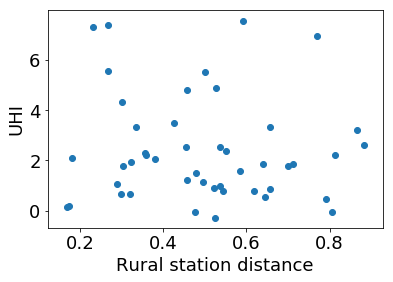

In [621]:
plt.scatter(
            paired_df['Rural distance'].loc[resultsDF.index],
            resultsDF[['Dry UHI', 'Moist UHI']].mean(axis=1),
)
plt.ylabel('UHI')
plt.xlabel('Rural station distance')

('Mean Difference is: ', 1.0205835940205672)


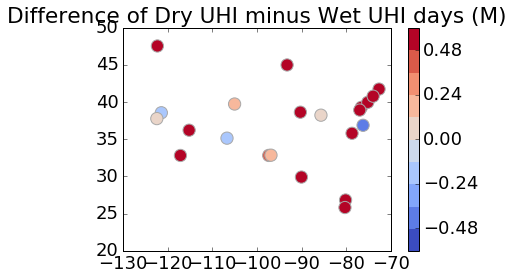

In [213]:
data = (resultsDF['DM'] - resultsDF['MM']).loc[good_index]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-.6,.6,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (M)')
print('Mean Difference is: ', data.mean())

('Mean Difference is: ', 1.1120770786590213)


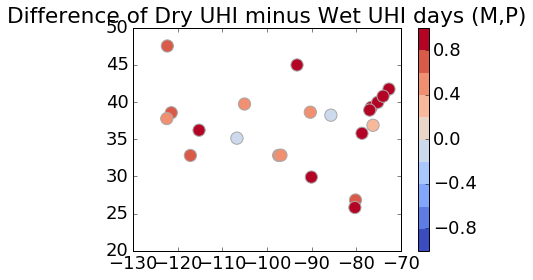

In [214]:
data = (resultsDF[['DM', 'DP']].mean(axis=1) - resultsDF[['MM', 'MP']].mean(axis=1)).loc[good_index]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (M,P)')
print('Mean Difference is: ', data.mean())

('Mean Difference is: ', 1.1382961636182123)


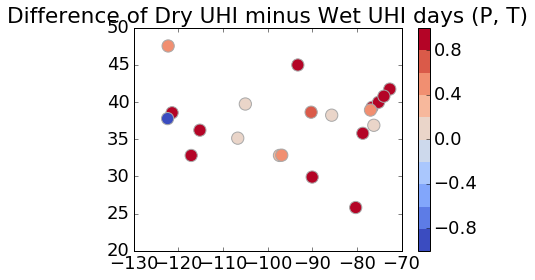

In [215]:
data = (resultsDF[['DP', 'DT']].mean(axis=1) - resultsDF[[ 'MP', 'MT', 'MTP']].mean(axis=1)).loc[good_index]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (P, T)')
print('Mean Difference is: ', data.mean())

('Mean Difference is: ', 1.2945930851406602)


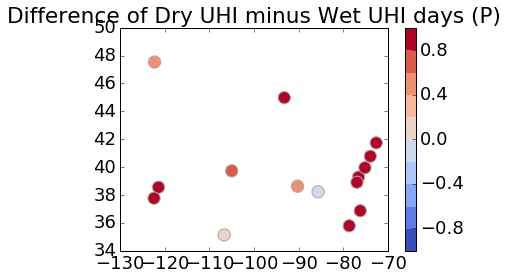

In [216]:
data =( resultsDF['DP'] - resultsDF['MP']).loc[good_index]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (P)')
print('Mean Difference is: ', data.mean())

('Mean Difference is: ', 0.7568697708610609)


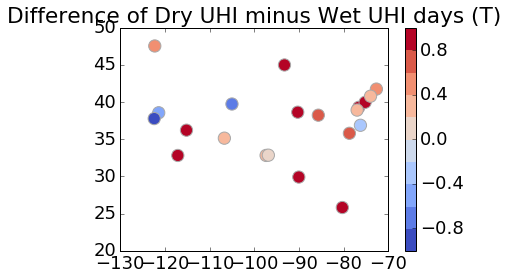

In [217]:
data = (resultsDF['DT'] - resultsDF['MT']).loc[good_index]
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (T)')
print('Mean Difference is: ', data.mean())

In [558]:
paired_df.index

Index(['Mesa', 'Grand Prairie', 'Irvine', 'New Haven', 'Fort Lauderdale',
       'Long Beach', 'Hartford', 'Providence', 'Birmingham', 'St. Petersburg',
       'Virginia Beach', 'Oakland', 'West Palm Beach', 'Louisville',
       'Charlotte', 'Columbus', 'San Bernardino', 'St. Paul', 'Tucson',
       'Fresno', 'Albuquerque', 'Kansas City', 'Tulsa', 'Ft. Worth', 'Austin',
       'El Paso', 'Orlando', 'Jacksonville', 'Indianapolis', 'Richmond',
       'Baltimore', 'San Jose', 'Sacramento', 'Las Vegas', 'Portland',
       'Salt Lake City', 'Omaha', 'Oklahoma City', 'San Antonio', 'Raleigh',
       'Cleveland', 'Cincinnati', 'Nashville', 'Memphis', 'Norfolk',
       'Milwaukee', 'Buffalo', 'Pittsburgh', 'Minneapolis', 'Honolulu',
       'Seattle', 'Phoenix', 'San Diego', 'St. Louis', 'New Orleans', 'Dallas',
       'Tampa', 'Philadelphia', 'Detroit', 'San Francisco', 'Denver',
       'Houston', 'Miami', 'Atlanta', 'Chicago', 'Los Angeles',
       'Washington, D.C.', 'New York'],
      dtype

Mean Difference is:  0.22216306999975577


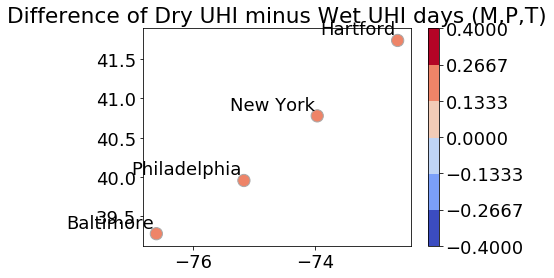

In [629]:
ne_cities = ['Hartford',  'New York',  'Baltimore',  'Philadelphia', 
             #'Washington, D.C.', 'Richmond','Norfolk',
             #'Providence',  'Buffalo', 'Pittsburgh',
            ]
data = resultsDF.loc[ne_cities]['Dry UHI'] - resultsDF.loc[ne_cities]['Moist UHI']
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-.4,.4,7)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, 
                         zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (M,P,T)')
for label, x, y in zip(c.index,paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, 2),
        textcoords='offset points', ha='right', va='bottom',
        bbox=None, #dict(boxstyle=None, fc='None', alpha=0.5),
        arrowprops=None, #dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    )
print('Mean Difference is: ', data.mean())

In [575]:
paired_df.loc[ne_cities]

,Unnamed: 0,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
City,,,,,,,,,,,,,
New Haven,3,USC00307134,40.961,-72.715,37.0,1938-03-01,2016-09-30,USC00065445,41.972,-73.220,7.0,1884-11-01 00:00:00,2016-12-31
Hartford,6,USW00014752,41.736,-72.650,62.0,1920-01-01,2016-12-31,USC00060227,41.841,-73.008,15.0,1990-08-01,2016-10-31
Providence,7,USC00379423,41.984,-71.490,60.0,1967-11-01,2016-10-31,USC00375270,41.856,-71.733,12.0,1974-10-01,2016-10-31
Richmond,30,USC00446656,37.238,-77.392,63.0,1980-06-01,2016-09-30,USC00442009,38.202,-77.374,5.0,1959-01-01,2016-11-30
Baltimore,31,USW00093784,39.281,-76.608,63.0,1998-05-01,2017-02-28,USC00185934,39.719,-76.802,13.0,1988-03-01,2016-08-31
Norfolk,45,USC00446147,36.870,-76.228,63.0,2003-04-01,2016-06-30,USC00448837,36.595,-76.438,5.0,2004-07-01,2016-07-31
Buffalo,47,USC00306047,43.021,-78.846,63.0,2004-01-01,2016-06-30,USC00301625,42.647,-78.711,18.0,2005-03-01,2016-10-31
Pittsburgh,48,USC00362574,40.501,-80.083,60.0,1991-09-01,2016-10-31,USC00365212,40.458,-79.450,10.0,1989-07-01,2016-07-31
Philadelphia,59,USC00366886,39.957,-75.172,63.0,1994-03-01,2016-06-30,USC00361080,40.500,-75.204,14.0,1978-12-01,2016-11-30


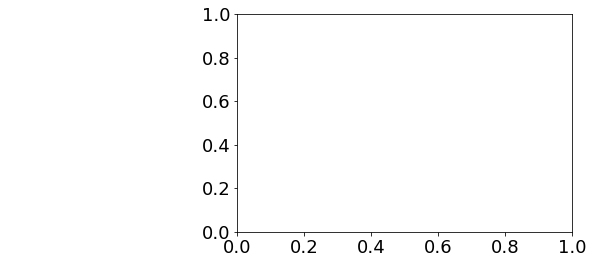

In [567]:
for label, x, y in zip(c.index,paired_df.loc[c.index]['Urban Lon'], paired_df.loc[c.index]['Urban Lat']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [568]:
label

'New York'

In [560]:
resultsDF.loc['Baltimore']

DM           4.840136
DP           4.881102
DT           5.053608
MM           4.860756
MP           4.321212
MT           4.661242
MTP          4.830000
Dry UHI      4.924949
Moist UHI    4.668302
Name: Baltimore, dtype: float64

In [451]:
UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index].mean(), UHI[synopticDF['ssc'][(synopticDF['ssc']>=4) & (synopticDF['ssc']<6)].index].mean()

(0.9778358208955232, 0.9543795620437939)

In [452]:
paired_df.loc['Baltimore']

Unnamed: 0                   36
City                  Baltimore
Urban station       USW00093721
Urban Lat                39.166
Urban Lon               -76.683
Urban brightness             63
Urban start          1939-07-01
Urban end            2016-09-30
Rural station       USC00182060
Rural Lat                39.655
Rural Lon               -76.175
Rural brightness             18
Rural start          1936-01-01
Rural end            2016-07-31
Name: Baltimore, dtype: object

In [453]:
resultsDF.loc['Baltimore']

Dry SSC UHI    1.000875
Wet SSC UHI    0.862396
Name: Baltimore, dtype: float64

In [428]:
resultsDF.head()

,Dry SSC UHI,Wet SSC UHI
City,,
Hartford,3.080081,2.924349
Providence,2.044955,2.014493
Birmingham,1.101379,0.900000
St. Petersburg,0.000000,0.000000
Oakland,-0.515288,-0.304046


In [430]:
(resultsDF['Dry SSC UHI'] - resultsDF['Wet SSC UHI']).mean()

0.03325455128009998

In [517]:
resultsDF.head()

,DM,DP,DT,MM,MP,MT,MTP
City,,,,,,,
Mesa,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grand Prairie,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Irvine,0.0,0.0,0.0,0.0,0.0,0.0,0.0
New Haven,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fort Lauderdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [516]:
import matplotlib
# define data
data = resultsDF['DM'] - resultsDF['Wet SSC UHI']
# Set up colors for plotting
cmap = matplotlib.cm.coolwarm
c = data
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 150

# plot data
plotHandle = plt.scatter(paired_df.set_index('City').loc[c.index]['Urban Lon'], paired_df.set_index('City').loc[c.index]['Urban Lat'], 
                        c = c.values, s = marker_size, alpha = 1, 
                        #transform=ccrs.Geodetic(), 
                        edgecolors = 'darkgray', 
                 cmap = cmap,
                 norm = norm, zorder = 1, )
plt.colorbar()
plt.title('Difference of Dry UHI minus Wet UHI days (M,P,T)')

KeyError: 'Dry SSC UHI'

In [461]:
paired_df.index

Index(['Hartford', 'Providence', 'Birmingham', 'St. Petersburg', 'Oakland',
       'West Palm Beach', 'Louisville', 'Charlotte', 'Columbus', 'Tucson',
       'Fresno', 'Albuquerque', 'Kansas City', 'Tulsa', 'Austin', 'El Paso',
       'Orlando', 'Jacksonville', 'Indianapolis', 'Richmond', 'Baltimore',
       'San Jose', 'Sacramento', 'Las Vegas', 'Portland', 'Salt Lake City',
       'Omaha', 'Oklahoma City', 'San Antonio', 'Raleigh', 'Cleveland',
       'Cincinnati', 'Nashville', 'Memphis', 'Norfolk', 'Buffalo',
       'Pittsburgh', 'Minneapolis', 'Honolulu', 'Seattle', 'Phoenix',
       'San Diego', 'St. Louis', 'New Orleans', 'Dallas', 'Tampa', 'Denver',
       'Houston', 'Miami', 'Atlanta', 'Chicago', 'Los Angeles',
       'Washington, D.C.'],
      dtype='object', name='City')

In [457]:
paired_df.loc[data[data<0].index]

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Urban start,Urban end,Rural station,Rural Lat,Rural Lon,Rural brightness,Rural start,Rural end
City,,,,,,,,,,,,,,
Oakland,16,Oakland,USC00046336,37.798,-122.264,63.0,1970-10-01,2016-10-31,USC00045915,37.879,-121.930,9.0,1952-04-01,2016-09-30
Charlotte,19,Charlotte,USW00013881,35.223,-80.955,63.0,1939-07-01,2016-09-30,USC00314996,35.460,-81.328,13.0,1952-04-01,2016-10-31
Kansas City,27,Kansas City,USW00013988,39.120,-94.596,63.0,1934-01-01,2016-09-30,USC00143686,38.664,-94.890,7.0,1985-02-01,2016-11-30
Austin,30,Austin,USW00013958,30.320,-97.760,63.0,1938-06-01,2016-09-30,USC00413686,30.718,-97.321,5.0,1980-07-01,2016-10-31
Jacksonville,33,Jacksonville,USC00084366,30.287,-81.392,61.0,1944-07-01,2016-09-30,USC00082915,29.755,-81.538,5.0,1892-01-01 00:00:00,2016-10-31
Indianapolis,34,Indianapolis,USW00093819,39.707,-86.280,62.0,1948-01-01,2016-09-30,USC00128784,40.223,-86.108,9.0,1971-08-01,2016-11-30
Richmond,35,Richmond,USC00444101,37.299,-77.277,62.0,1916-10-01,2016-10-31,USC00448829,37.743,-77.040,6.0,1932-07-01,2016-07-31
San Jose,37,San Jose,USW00023244,37.405,-122.048,63.0,1945-03-01,2016-09-30,USC00045933,37.343,-121.642,5.0,1948-07-01,2016-09-30
Sacramento,38,Sacramento,USW00023271,38.555,-121.416,63.0,1877-07-01 00:00:00,2016-09-30,USC00043384,38.933,-120.800,4.0,1954-01-01,2016-10-31


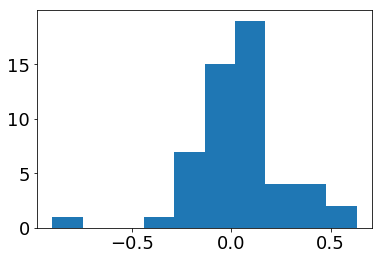

In [445]:
handle = plt.hist(data)

In [449]:
data.describe()

count    53.000000
mean      0.033255
std       0.238053
min      -0.901607
25%      -0.075105
50%       0.028551
75%       0.138479
max       0.631813
dtype: float64

In [15]:
results_filepath = 'plots/version5/ssc/'

In [313]:
results_filepath = 'plots/version5/ssc/'
cities = ['Birmingham', 'Albuquerque', 'Buffalo', 'Washington, D.C.','Miami','Phoenix','Seattle', 'Baltimore', 'Hartford', 
         'Providence', 'Oakland' 'West Palm Beach', 'Louisville', 'Charlotte', 'Columbus', 'Tucson', 'Fresno', 
         'Kansas City', 'Tulsa', 'Austin', 'El Paso', 'Orlando', 'Jacksonville', 'Indiapolis', 
         'Richmond', 'San Jose', 'Sacramento', 'Las Vegas', 'Portland', 'Salt Lake City', 'Omaha', 'Oklahoma City'
         ]
stations = ['bhm', 'abq', 'buf', 'iad', 'mia', 'phx', 'sea', 'iad', 'bdl', 'pvd', 'oak', 'pbi', 'sdf', 'clt', 'cmh', 'tus', 'fat', 
           'mci', 'tul', 'aus', 'elp', 'mco', 'jax', 'ind', 
           'ric', 'sjc', 'sac', 'pdx', 'slc', 'oma', 'okc']
resultsDF = pd.DataFrame(np.zeros([len(cities), 3]), index = cities, columns=['m', 'r', 'p'])

In [470]:
#mkdir plots/version5/ssc/
#!mkdir plots/version5/firstanalysis/

In [472]:
paired_df = pairs

In [473]:
# given a few cities and their SSC classification data, 
# explore relationship between UHI and SSC
cities = ['Birmingham', 'Albuquerque', 'Buffalo', 'Washington, D.C.','Miami','Phoenix','Seattle', 'Baltimore', 'Hartford', 
#          'Providence', 'Oakland' 'West Palm Beach', 'Louisville', 'Charlotte', 'Columbus', 'Tucson', 'Fresno', 
#          'Kansas City', 'Tulsa', 'Austin', 'El Paso', 'Orlando', 'Jacksonville', 'Indiapolis', 
#          'Richmond', 'San Jose', 'Sacramento', 'Las Vegas', 'Portland', 'Salt Lake City', 'Omaha', 'Oklahoma City'
         ]
stations = ['bhm', 'abq', 'buf', 'iad', 'mia', 'phx', 'sea', 'iad', 'bdl', 
#             'pvd', 'oak', 'pbi', 'sdf', 'clt', 'cmh', 'tus', 'fat', 
#            'mci', 'tul', 'aus', 'elp', 'mco', 'jax', 'ind', 
#            'ric', 'sjc', 'sac', 'pdx', 'slc', 'oma', 'okc'
           ]
resultsDF = pd.DataFrame(np.zeros([len(cities), 2]), index = cities, 
                         columns=['Dry SSC UHI', 'Wet SSC UHI'])
for city,station in zip(cities,stations): 
# # read in ssc data 
# city = 'Baltimore'
# station = 'iad'
# station = 'bhm'
    print(city)
    #     synopticDF =pd.read_table(filepath+station+'.txt', 
    #                           sep = ' ', header = None,#nrows = 5, 
    #                               index_col = 1,
    #               parse_dates = [1], infer_datetime_format = True)
    #     synopticDF.index = pd.DatetimeIndex(synopticDF.index, freq = 'D', 
    #                                         dtype = 'period[D]', 
    #                                         name = 'month_period')
    #     synopticDF.columns = ['id','ssc']
    #     synopticDF['ssc'][synopticDF['ssc']> 60] = synopticDF['ssc'][synopticDF['ssc']> 60]/10.
    synopticDF = pd.read_table(filepath+station+'.txt', 
                              sep = ' ', header = None,)
    synopticDF.index = pd.PeriodIndex(synopticDF.index, freq = 'D', name = 'month_period')
    synopticDF.columns = ['id','date', 'ssc']
    synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
    synopticDF = synopticDF.loc['2005-06-01':]

    # read in UHI data
    urbanID = paired_df.loc[city]['Urban station']
    ruralID = paired_df.loc[city]['Rural station']
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    rural_tmin = pd.to_numeric(ruraldata['TMIN']['2005-06-01':].value/10.) #rural tmin
    urban_tmin = pd.to_numeric(urbandata['TMIN']['2005-06-01':].value/10.) 
    
    # extract summertime data 
    rural_summer = rural_tmin[(rural_tmin.index.month >= 6) & (rural_tmin.index.month <= 8)]
    urban_summer = urban_tmin[(urban_tmin.index.month >= 6) & (urban_tmin.index.month <= 8)]

    # clean data: eliminate min temperatures below 4 or above 35
    #rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    #urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    #UHI = urban_summer - rural_summer

    # Figure 1: timeseries from 2016
#     f, axes = plt.subplots(nrows=1,ncols=2, figsize =[15,5])
#     UHI['2016-06-01':].plot(ax = axes[0])
#     synopticDF.loc['2016-06-01':'2016-08-31']['ssc'].plot(ax = axes[0])
#     axes[0].legend(['UHI', 'SSC'])
#     axes[0].set_title('2016 UHI and SSC %s'%city)
#     plt.subplot(122)
#     m,r,p = easy_scatter(synopticDF['ssc'].loc[UHI.index].values,
#                          UHI.values,
#                          title='%s'%city, xlabel='SSC',
#                          ylabel='UHI',)
#    r, p = scipy.stats.pearsonr(synopticDF['ssc'].loc[UHI.index].values)
    mean_UHI_dry_ssc = UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index].mean()
    mean_UHI_wet_ssc = UHI[synopticDF['ssc'][(synopticDF['ssc']>=4) & (synopticDF['ssc']<7)].index].mean()

    #plt.savefig(results_filepath+ '%s.png'%city)
    plt.close()

    resultsDF.loc[city]  = [mean_UHI_dry_ssc, mean_UHI_wet_ssc]
    #resultsDF.columns = ['Dry SSC UHI', 'Wet SSC UHI', 'r']
    resultsDF.to_csv(results_filepath+'sscanalysis_2005pairs.csv')

Birmingham


/Users/ascott47/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  axis=1)
/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:95: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead

Albuquerque
Buffalo
Washington, D.C.
Miami
Phoenix
Seattle
Baltimore


/Users/ascott47/anaconda/lib/python3.6/site-packages/ulmo/ncdc/ghcn_daily/core.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe[column_name][dates] = element_df[col][months]


Hartford


In [474]:
resultsDF

,Dry SSC UHI,Wet SSC UHI
Birmingham,1.625959,0.731416
Albuquerque,0.846259,1.436250
Buffalo,1.017634,0.933472
"Washington, D.C.",1.151643,0.814931
Miami,0.948837,0.997324
Phoenix,1.077105,0.790584
Seattle,0.893383,1.085583
Baltimore,1.151643,0.814931
Hartford,0.868738,1.088528


In [479]:
resultsDF

,Dry SSC UHI,Wet SSC UHI
Birmingham,1.625959,0.731416
Albuquerque,0.846259,1.436250
Buffalo,1.017634,0.933472
"Washington, D.C.",1.151643,0.814931
Miami,0.948837,0.997324
Phoenix,1.077105,0.790584
Seattle,0.893383,1.085583
Baltimore,1.151643,0.814931
Hartford,0.868738,1.088528


In [476]:
(resultsDF['Dry SSC UHI'] - resultsDF['Wet SSC UHI']).mean()

0.09868703755104109

In [316]:
resultsDF

,Dry SSC UHI,Wet SSC UHI,r
Birmingham,1.139018,0.973113,NaN
Albuquerque,12.061750,11.613084,NaN
Buffalo,2.653998,2.598042,NaN
"Washington, D.C.",0.906040,1.084868,NaN
Miami,1.624675,1.355408,NaN
Phoenix,3.009735,1.967857,NaN
Seattle,2.701012,2.839286,NaN
Baltimore,1.036432,0.831086,NaN


In [330]:
resultsDF['Dry SSC UHI'] - resultsDF['Wet SSC UHI']

Birmingham          0.165905
Albuquerque         0.448666
Buffalo             0.055956
Washington, D.C.   -0.178828
Miami               0.269267
Phoenix             1.041877
Seattle            -0.138274
Baltimore           0.205346
dtype: float64

In [329]:
# using marine, polar, and tropical air
alldf = pd.read_csv(results_filepath+'sscanalysis.csv').set_index('Unnamed: 0')
alldf['Dry SSC UHI']- alldf['Wet SSC UHI']

Unnamed: 0
Birmingham          0.212753
Albuquerque         0.333442
Buffalo             0.040349
Washington, D.C.   -0.168198
Miami              -0.009541
Phoenix             0.239302
Seattle            -0.156895
Baltimore           0.135836
dtype: float64

In [333]:
UHI = urban_tmin - rural_tmin
UHI.mean()

1.0324540935375928

In [332]:
UHI.mean()

0.917319098457887

In [319]:
alldf

,Unnamed: 0,Dry SSC UHI,Wet SSC UHI,r
0,Birmingham,1.101379,0.888626,-0.055804
1,Albuquerque,12.066536,11.733094,-0.032418
2,Buffalo,2.667524,2.627175,-0.004886
3,"Washington, D.C.",0.921422,1.089620,0.032865
4,Miami,1.646154,1.655695,0.039272
5,Phoenix,2.497802,2.258500,-0.068769
6,Seattle,2.701761,2.858656,0.040423
7,Baltimore,0.999299,0.863463,-0.023325


In [334]:
mean_UHI_dry_ssc = UHI[synopticDF['ssc'][synopticDF['ssc']<=2].index].mean()
mean_UHI_wet_ssc = UHI[synopticDF['ssc'][(synopticDF['ssc']>=4) & (synopticDF['ssc']<6)].index].mean()


In [335]:
mean_UHI_dry_ssc

1.0755964553510597

In [336]:
mean_UHI_wet_ssc

1.0425503355704715

In [294]:
resultsDF.columns = ['Dry SSC UHI', 'Wet SSC UHI', 'r']
resultsDF.to_csv(results_filepath+'sscanalysis.csv')

In [296]:
results_filepath

'plots/version5/ssc/'

In [295]:
resultsDF

,Dry SSC UHI,Wet SSC UHI,r
Birmingham,1.101379,0.888626,-0.055804
Albuquerque,12.066536,11.733094,-0.032418
Buffalo,2.667524,2.627175,-0.004886
"Washington, D.C.",0.921422,1.089620,0.032865
Miami,1.646154,1.655695,0.039272
Phoenix,2.497802,2.258500,-0.068769
Seattle,2.701761,2.858656,0.040423
Baltimore,0.999299,0.863463,-0.023325


In [209]:
resultsDF.to_csv(results_filepath+'sscanalysis.csv')

In [240]:
synopticDF.head()

,0,1,2
month_period,,,
1970-01-01,SEA,19480101,8
1970-01-02,SEA,19480102,5
1970-01-03,SEA,19480103,5
1970-01-04,SEA,19480104,5
1970-01-05,SEA,19480105,1


In [264]:
synopticDF = pd.read_table(filepath+station+'.txt', 
                          sep = ' ', header = None,  
                              )
synopticDF.index = pd.PeriodIndex(synopticDF.index, freq = 'D', name = 'month_period')
synopticDF.columns = ['id','date', 'ssc']
synopticDF['ssc'].loc[synopticDF['ssc']> 60] =6.5
synopticDF = synopticDF.loc['1985-06-01':]

/Users/ascott47/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [269]:
mean_UHI_dry_ssc = UHI[synopticDF['ssc'][synopticDF['ssc']<=3].index].mean()
mean_UHI_wet_ssc = UHI[synopticDF['ssc'][(synopticDF['ssc']<=4) & (synopticDF['ssc']<=7)].index].mean()

In [232]:
UHI.index

PeriodIndex(['1985-06-01', '1985-06-02', '1985-06-03', '1985-06-04',
             '1985-06-05', '1985-06-06', '1985-06-07', '1985-06-08',
             '1985-06-09', '1985-06-10',
             ...
             '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25',
             '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29',
             '2016-08-30', '2016-08-31'],
            dtype='period[D]', name='month_period', length=2931, freq='D')

In [235]:
test[2][UHI.index]

month_period
1985-06-01    1
1985-06-02    5
1985-06-03    2
1985-06-04    5
1985-06-05    5
1985-06-06    4
1985-06-07    5
1985-06-08    5
1985-06-09    5
1985-06-10    1
1985-06-11    4
1985-06-12    4
1985-06-13    1
1985-06-14    1
1985-06-15    3
1985-06-16    3
1985-06-17    7
1985-06-18    4
1985-06-19    4
1985-06-20    2
1985-06-21    5
1985-06-22    5
1985-06-23    2
1985-06-24    5
1985-06-25    2
1985-06-26    7
1985-06-27    5
1985-06-28    5
1985-06-29    5
1985-06-30    2
             ..
2016-08-02    1
2016-08-03    4
2016-08-04    1
2016-08-05    1
2016-08-06    1
2016-08-07    1
2016-08-08    5
2016-08-09    1
2016-08-10    1
2016-08-11    1
2016-08-12    1
2016-08-13    1
2016-08-14    1
2016-08-15    1
2016-08-16    1
2016-08-17    1
2016-08-18    1
2016-08-19    1
2016-08-20    1
2016-08-21    1
2016-08-22    4
2016-08-23    1
2016-08-24    1
2016-08-25    1
2016-08-26    1
2016-08-27    3
2016-08-28    1
2016-08-29    1
2016-08-30    1
2016-08-31    1
Freq: D, Na

In [142]:
synopticDF =pd.read_table(filepath+station+'.txt', 
                      sep = ' ', header = None,#nrows = 5, 
                          index_col = 1,
          parse_dates = [1], infer_datetime_format = True)
synopticDF.index = pd.DatetimeIndex(synopticDF.index, freq = 'D', 
                                    dtype = 'period[D]', 
                                    name = 'month_period')
synopticDF.columns = ['id','ssc']
synopticDF['ssc'][synopticDF['ssc']> 60] = synopticDF['ssc'][synopticDF['ssc']> 60]/10.
synopticDF.head()

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,id,ssc
month_period,,
1942-01-01,BHM,8.0
1942-01-02,BHM,8.0
1942-01-03,BHM,8.0
1942-01-04,BHM,8.0
1942-01-05,BHM,8.0


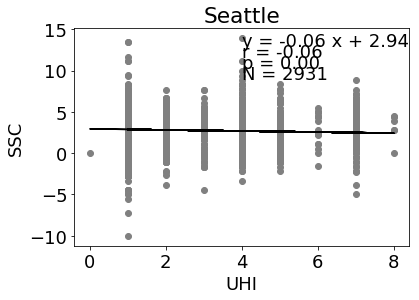

In [213]:
 m,r,p = easy_scatter(synopticDF['ssc'].loc[UHI.index.to_timestamp()].values,
                         UHI.values,
                         title='%s'%city, ylabel='SSC',
                         xlabel='UHI',)

In [218]:
synopticDF.loc['2016-06-01':'2016-08-31']['ssc']< 3

month_period
2016-06-01     True
2016-06-02    False
2016-06-03     True
2016-06-04    False
2016-06-05    False
2016-06-06    False
2016-06-07    False
2016-06-08    False
2016-06-09    False
2016-06-10    False
2016-06-11     True
2016-06-12     True
2016-06-13    False
2016-06-14    False
2016-06-15     True
2016-06-16     True
2016-06-17     True
2016-06-18    False
2016-06-19     True
2016-06-20     True
2016-06-21    False
2016-06-22     True
2016-06-23    False
2016-06-24    False
2016-06-25     True
2016-06-26     True
2016-06-27     True
2016-06-28     True
2016-06-29    False
2016-06-30    False
              ...  
2016-08-02    False
2016-08-03     True
2016-08-04    False
2016-08-05     True
2016-08-06     True
2016-08-07    False
2016-08-08    False
2016-08-09    False
2016-08-10    False
2016-08-11     True
2016-08-12     True
2016-08-13    False
2016-08-14     True
2016-08-15     True
2016-08-16     True
2016-08-17     True
2016-08-18     True
2016-08-19    False
2016-08

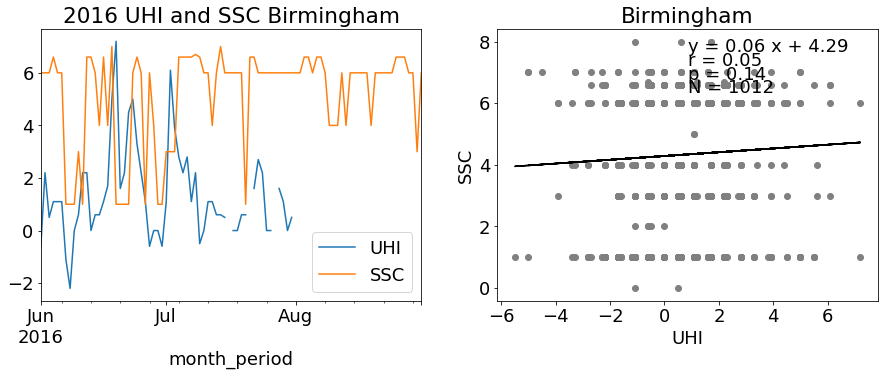

In [204]:
# Figure 1: timeseries from 2016
f, axes = plt.subplots(nrows=1,ncols=2, figsize =[15,5])
UHI['2016-06-01':].plot(ax = axes[0])
synopticDF.loc['2016-06-01':'2016-08-31']['ssc'].plot(ax = axes[0])
axes[0].legend(['UHI', 'SSC'])
axes[0].set_title('2016 UHI and SSC %s'%city)
plt.subplot(122)
m,r,p = easy_scatter(UHI.values,
                     synopticDF['ssc'].loc[UHI.index.to_timestamp()].values,
                     title='%s'%city,
                     xlabel='UHI', ylabel='SSC')

plt.savefig(results_filepath+ '%s.png'%city)

In [208]:
resultsDF.loc['Birmingham']  = [0.061188,
                                0.047059,
                                0.14242]

In [201]:
resultsDF

,m,r,p
Birmingham,0.061188,0.047059,0.14242
Albuquerque,0.000000,0.000000,0.00000
Buffalo,0.000000,0.000000,0.00000
"Washington, D.C.",0.000000,0.000000,0.00000
Miami,0.000000,0.000000,0.00000
Phoenix,0.000000,0.000000,0.00000
Seattle,0.000000,0.000000,0.00000


In [199]:
resultsDF = pd.DataFrame(np.zeros([len(cities), 3]), index = cities, columns=['m', 'r', 'p'])

In [188]:
results_filepath = 'plots/version5/ssc/'

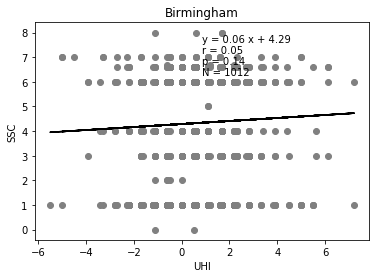

In [159]:
# Figure 2: scatterplot
m,r,p = easy_scatter(UHI.values,
                     synopticDF['ssc'].loc[UHI.index.to_timestamp()].values,
                     title='%s'%city,
                     xlabel='UHI', ylabel='SSC')
plt.savefig(results_filepath+ 'ssc/%s.png'%city)

In [156]:
UHI.shape, synopticDF['ssc'].loc[UHI.index.to_timestamp()].shape

((1012,), (1012,))

In [143]:
synopticDF.index

DatetimeIndex(['1942-01-01', '1942-01-02', '1942-01-03', '1942-01-04',
               '1942-01-05', '1942-01-06', '1942-01-07', '1942-01-08',
               '1942-01-09', '1942-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='month_period', length=27394, freq='D')

In [140]:
UHI.index.to_datetime()

/Users/ascott47/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: to_datetime is deprecated. Use self.to_timestamp(...)
  if __name__ == '__main__':


DatetimeIndex(['2006-06-01', '2006-06-02', '2006-06-03', '2006-06-04',
               '2006-06-05', '2006-06-06', '2006-06-07', '2006-06-08',
               '2006-06-09', '2006-06-10',
               ...
               '2016-08-22', '2016-08-23', '2016-08-24', '2016-08-25',
               '2016-08-26', '2016-08-27', '2016-08-28', '2016-08-29',
               '2016-08-30', '2016-08-31'],
              dtype='datetime64[ns]', name='month_period', length=1012, freq=None)

In [153]:
synopticDF['ssc'].loc[UHI.index.to_timestamp()]

month_period
2006-06-01    6.0
2006-06-02    6.0
2006-06-03    1.0
2006-06-04    1.0
2006-06-05    1.0
2006-06-06    1.0
2006-06-07    3.0
2006-06-08    1.0
2006-06-09    1.0
2006-06-10    3.0
2006-06-11    3.0
2006-06-12    6.0
2006-06-13    6.0
2006-06-14    1.0
2006-06-15    3.0
2006-06-16    3.0
2006-06-17    3.0
2006-06-18    1.0
2006-06-19    1.0
2006-06-20    3.0
2006-06-21    3.0
2006-06-22    3.0
2006-06-23    6.0
2006-06-24    6.0
2006-06-25    6.0
2006-06-26    6.0
2006-06-27    1.0
2006-06-28    1.0
2006-06-29    1.0
2006-06-30    1.0
             ... 
2016-08-02    6.0
2016-08-03    6.6
2016-08-04    6.6
2016-08-05    6.0
2016-08-06    6.6
2016-08-07    6.6
2016-08-08    6.0
2016-08-09    4.0
2016-08-10    4.0
2016-08-11    4.0
2016-08-12    6.0
2016-08-13    4.0
2016-08-14    6.0
2016-08-15    6.0
2016-08-16    6.0
2016-08-17    6.0
2016-08-18    6.0
2016-08-19    4.0
2016-08-20    6.0
2016-08-21    6.0
2016-08-22    6.0
2016-08-23    6.0
2016-08-24    6.0
2016-08-25    6